In [3]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import tensorflow as tf

import timeit
from datetime import datetime
import math
import datetime

In [4]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# 基础知识

## Eager Execution（即刻执行）
2个基本模式

- eager execution模式，pytorch一样，如果要关闭：tf.compat.v1.disable_eager_execution()
- graph execution模式，静态图，调用时执行

In [26]:
import os
import tensorflow as tf
import cProfile

In [30]:
# 是否启用
print(tf.executing_eagerly())

# test
x = [[2.]]
m = tf.matmul(x, x)
print("hello, {}".format(m))

True
hello, [[4.]]


In [7]:
# 2.0下图模式，tf.function,调用函数时才执行
@tf.function
def f(x, y):
  return x ** 2 + y
x = tf.constant([2, 3])
y = tf.constant([3, -2])
c = f(x, y)
c

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([7, 7], dtype=int32)>

In [47]:
# 动态流控制：如pytorch一样
def fizzbuzz(max_num):
  counter = tf.constant(0)
  max_num = tf.convert_to_tensor(max_num)
  for num in range(1, max_num.numpy()+1):
    num = tf.constant(num)
    if int(num % 3) == 0 and int(num % 5) == 0:
      print('FizzBuzz')
    elif int(num % 3) == 0:
      print('Fizz')
    elif int(num % 5) == 0:
      print('Buzz')
    else:
      print(num.numpy())
    counter += 1
fizzbuzz(15)

1
2
Fizz
4
Buzz
Fizz
7
8
Fizz
Buzz
11
Fizz
13
14
FizzBuzz


### 训练
#### 计算梯度：自动微分

In [50]:
w = tf.Variable([[5.0]])
with tf.GradientTape() as tape:
  loss = w * w

grad = tape.gradient(loss, w)
print(grad) 

tf.Tensor([[10.]], shape=(1, 1), dtype=float32)


#### 训练模型：自定义模型
例子中使用自定义训练过程，参考《模型构建方法》，还可以使用kears的fit，用callback+tensorboard展现结果

In [4]:
# GPU内存不足问题
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"  #选择哪一块gpu
config = ConfigProto()
config.allow_soft_placement=True #如果你指定的设备不存在，允许TF自动分配设备
config.gpu_options.per_process_gpu_memory_fraction=0.7  #分配百分之七十的显存给程序使用，避免内存溢出，可以自己调整
config.gpu_options.allow_growth = True   #按需分配显存，这个比较重要
session = InteractiveSession(config=config)

In [5]:
# Fetch and format the mnist data
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(mnist_images[...,tf.newaxis]/255, tf.float32),
   tf.cast(mnist_labels,tf.int64)))
dataset = dataset.shuffle(1000).batch(32)

# Build the model
mnist_model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16,[3,3], activation='relu',
                         input_shape=(None, None, 1)),
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10)
])

In [8]:
# 即使没有训练，也可以在 Eager Execution 中调用模型并检查输出
for images,labels in dataset.take(1):
  print("Logits: ", mnist_model(images[0:1]).numpy())

Logits:  [[-0.01480014 -0.01041786  0.01230434 -0.04272166 -0.03904635  0.02555244
  -0.02262816  0.02003777 -0.00545612 -0.03585812]]


In [9]:
# 自定义训练，不使用keras的fit
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_history = []

# 请在 tf.debugging 中使用断言函数检查条件是否成立。这在 Eager Execution 和计算图执行中均有效
def train_step(images, labels):
  with tf.GradientTape() as tape:
    logits = mnist_model(images, training=True)

    # Add asserts to check the shape of the output.
    tf.debugging.assert_equal(logits.shape, (32, 10))

    loss_value = loss_object(labels, logits)

  loss_history.append(loss_value.numpy().mean())
  grads = tape.gradient(loss_value, mnist_model.trainable_variables)
  optimizer.apply_gradients(zip(grads, mnist_model.trainable_variables))

In [11]:
def train(epochs):
  for epoch in range(epochs):
    for (batch, (images, labels)) in enumerate(dataset):
      train_step(images, labels)
    print ('Epoch {} finished'.format(epoch))

In [12]:
train(epochs = 3)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished


Text(0, 0.5, 'Loss [entropy]')

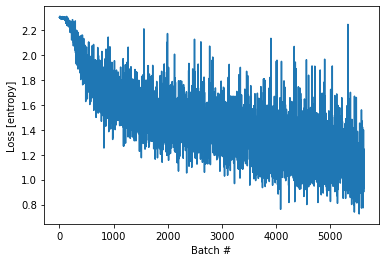

In [13]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')

### 变量与优化器

tf.Variable 对象会存储在训练期间访问的可变、类似于 tf.Tensor 的值，以更简单地实现自动微分。

层和模型之间的主要区别在于模型添加了如下方法：Model.fit、Model.evaluate 和 Model.save。

In [15]:
class Linear(tf.keras.Model):
  def __init__(self):
    super(Linear, self).__init__()
    self.W = tf.Variable(5., name='weight')
    self.B = tf.Variable(10., name='bias')
  def call(self, inputs):
    return inputs * self.W + self.B

In [16]:
# A toy dataset of points around 3 * x + 2
NUM_EXAMPLES = 2000
training_inputs = tf.random.normal([NUM_EXAMPLES])
noise = tf.random.normal([NUM_EXAMPLES])
training_outputs = training_inputs * 3 + 2 + noise

# The loss function to be optimized
def loss(model, inputs, targets):
  error = model(inputs) - targets
  return tf.reduce_mean(tf.square(error))

def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return tape.gradient(loss_value, [model.W, model.B])

#### 核心部件构建与训练
1. 创建模型
2. 损失函数对模型参数的导数。
3. 基于导数的变量更新策略。

In [17]:
model = Linear()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

print("Initial loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))

steps = 300
for i in range(steps):
  grads = grad(model, training_inputs, training_outputs)
  optimizer.apply_gradients(zip(grads, [model.W, model.B]))
  if i % 20 == 0:
    print("Loss at step {:03d}: {:.3f}".format(i, loss(model, training_inputs, training_outputs)))

Initial loss: 69.966
Loss at step 000: 67.219
Loss at step 020: 30.377
Loss at step 040: 14.032
Loss at step 060: 6.782
Loss at step 080: 3.565
Loss at step 100: 2.138
Loss at step 120: 1.505
Loss at step 140: 1.224
Loss at step 160: 1.099
Loss at step 180: 1.044
Loss at step 200: 1.019
Loss at step 220: 1.008
Loss at step 240: 1.003
Loss at step 260: 1.001
Loss at step 280: 1.000


In [18]:
print("Final loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))

Final loss: 1.000


In [19]:
print("W = {}, B = {}".format(model.W.numpy(), model.B.numpy()))

W = 2.981884717941284, B = 1.9878385066986084


注：变量将一直存在，直至删除对 Python 对象的最后一个引用，并删除该变量。

#### 基于对象的保存(添加checkpoint，以查看优化训练)
tf.keras.Model 包括一个方便的 save_weights 方法，您可以通过该方法轻松创建检查点：

您可以使用 tf.train.Checkpoint 完全控制此过程。

本部分是检查点训练指南的缩略版。

In [25]:
model.save_weights('weights')
status = model.load_weights('weights')

In [26]:
x = tf.Variable(10.)
checkpoint = tf.train.Checkpoint(x=x)

In [27]:
x.assign(2.)   # Assign a new value to the variables and save.
checkpoint_path = '../learnMLData/ckpt/'
checkpoint.save('./../learnMLData/ckpt/')

'./../learnMLData/ckpt/-1'

In [28]:
x.assign(11.)  # Change the variable after saving.

# Restore values from the checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

print(x)  # => 2.0

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>


要保存和加载模型，tf.train.Checkpoint 会存储对象的内部状态，而无需隐藏变量。要记录 model、optimizer 和全局步骤的状态，请将它们传递到 tf.train.Checkpoint：

In [30]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
checkpoint_dir = '../learnMLData/path/to/model_dir'
if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
root = tf.train.Checkpoint(optimizer=optimizer,
                           model=model)

root.save(checkpoint_prefix)
root.restore(tf.train.latest_checkpoint(checkpoint_dir))

注：在许多训练循环中，会在调用 tf.train.Checkpoint.restore 后创建变量。这些变量将在创建后立即恢复，并且可以使用断言来确保检查点已完全加载。有关详细信息，请参阅检查点训练指南。

### 面向对象的指标
tf.keras.metrics 会被存储为对象。可以通过将新数据传递给可调用对象来更新指标，并使用 tf.keras.metrics.result 方法检索结果，例如：

In [32]:
m = tf.keras.metrics.Mean("loss")
m(0)
m(5)
m.result()  # => 2.5
m([8, 9])
m.result()  # => 5.5

<tf.Tensor: shape=(), dtype=float32, numpy=5.5>

### 自动微分高级主题
#### 动态模型
tf.GradientTape 也可以用于动态模型。下面这个回溯线搜索算法示例看起来就像普通的 NumPy 代码，但它的控制流比较复杂，存在梯度且可微分：

In [35]:
def line_search_step(fn, init_x, rate=1.0):
  with tf.GradientTape() as tape:
    # Variables are automatically tracked.
    # But to calculate a gradient from a tensor, you must `watch` it.
    tape.watch(init_x)
    value = fn(init_x)
  grad = tape.gradient(value, init_x)
  grad_norm = tf.reduce_sum(grad * grad)
  init_value = value
  while value > init_value - rate * grad_norm:
    x = init_x - rate * grad
    value = fn(x)
    rate /= 2.0
  return x, value

#### 自定义梯度
自定义梯度是重写梯度的一种简单方法。在前向函数中，定义相对于输入、输出或中间结果的梯度。例如，下面是在后向传递中裁剪梯度范数的一种简单方法：

In [36]:
@tf.custom_gradient
def clip_gradient_by_norm(x, norm):
  y = tf.identity(x)
  def grad_fn(dresult):
    return [tf.clip_by_norm(dresult, norm), None]
  return y, grad_fn

自定义梯度通常用来为运算序列提供数值稳定的梯度：

In [37]:
def log1pexp(x):
  return tf.math.log(1 + tf.exp(x))

def grad_log1pexp(x):
  with tf.GradientTape() as tape:
    tape.watch(x)
    value = log1pexp(x)
  return tape.gradient(value, x)
# The gradient computation works fine at x = 0.
grad_log1pexp(tf.constant(0.)).numpy()

0.5

In [38]:
# However, x = 100 fails because of numerical instability.
grad_log1pexp(tf.constant(100.)).numpy()

nan

在此例中，log1pexp 函数可以通过自定义梯度进行分析简化。下面的实现重用了在前向传递期间计算的 tf.exp(x) 值，通过消除冗余计算使其变得更加高效：

In [39]:
@tf.custom_gradient
def log1pexp(x):
  e = tf.exp(x)
  def grad(dy):
    return dy * (1 - 1 / (1 + e))
  return tf.math.log(1 + e), grad

def grad_log1pexp(x):
  with tf.GradientTape() as tape:
    tape.watch(x)
    value = log1pexp(x)
  return tape.gradient(value, x)


In [40]:
# As before, the gradient computation works fine at x = 0.
grad_log1pexp(tf.constant(0.)).numpy()

0.5

In [41]:
# And the gradient computation also works at x = 100.
grad_log1pexp(tf.constant(100.)).numpy()

1.0

#### 性能
在 Eager Execution 期间，计算会自动分流到 GPU。如果想控制计算运行的位置，可将其放在 tf.device('/gpu:0') 块（或 CPU 等效块）中：

In [42]:
import time

def measure(x, steps):
  # TensorFlow initializes a GPU the first time it's used, exclude from timing.
  tf.matmul(x, x)
  start = time.time()
  for i in range(steps):
    x = tf.matmul(x, x)
  # tf.matmul can return before completing the matrix multiplication
  # (e.g., can return after enqueing the operation on a CUDA stream).
  # The x.numpy() call below will ensure that all enqueued operations
  # have completed (and will also copy the result to host memory,
  # so we're including a little more than just the matmul operation
  # time).
  _ = x.numpy()
  end = time.time()
  return end - start

shape = (1000, 1000)
steps = 200
print("Time to multiply a {} matrix by itself {} times:".format(shape, steps))

# Run on CPU:
with tf.device("/cpu:0"):
  print("CPU: {} secs".format(measure(tf.random.normal(shape), steps)))

# Run on GPU, if available:
if tf.config.experimental.list_physical_devices("GPU"):
  with tf.device("/gpu:0"):
    print("GPU: {} secs".format(measure(tf.random.normal(shape), steps)))
else:
  print("GPU: not found")

Time to multiply a (1000, 1000) matrix by itself 200 times:
CPU: 0.6599118709564209 secs
GPU: 0.1941068172454834 secs


可以将 tf.Tensor 对象复制到不同设备来执行其运算：

In [43]:
if tf.config.experimental.list_physical_devices("GPU"):
  x = tf.random.normal([10, 10])

  x_gpu0 = x.gpu()
  x_cpu = x.cpu()

  _ = tf.matmul(x_cpu, x_cpu)    # Runs on CPU
  _ = tf.matmul(x_gpu0, x_gpu0)  # Runs on GPU:0

Instructions for updating:
Use tf.identity instead.
Instructions for updating:
Use tf.identity instead.


### 基准
对于计算量繁重的模型（如在 GPU 上训练的 ResNet50），Eager Execution 性能与 tf.function 执行相当。但是对于计算量较小的模型来说，这种性能差距会越来越大，并且在为有大量小运算的模型优化热代码路径方面，其性能还有待提升。

### 使用函数
虽然 Eager Execution 增强了开发和调试的交互性，但 TensorFlow 1.x 样式的计算图执行在分布式训练、性能优化和生产部署方面具有优势。为了弥补这一差距，TensorFlow 2.0 通过 tf.function API 引入了 function。有关详细信息，请参阅 tf.function 指南。

## 张量
张量属性：
- 单一数据类型。但是元素类型可以很多样
- a shape


参考:[Tensor](https://tensorflow.google.cn/versions/r2.3/api_docs/python/tf/Tensor?hl=zh_cn)

支持类型：[DType](https://tensorflow.google.cn/api_docs/python/tf/dtypes/DType?hl=zh_cn)

### 关注轴的概念：标量0轴，向量1轴，以此类推

In [49]:
# This will be an int32 tensor by default; see "dtypes" below.
rank_0_tensor = tf.constant(4)
print(rank_0_tensor)

# Let's make this a float tensor.1秩向量，1轴。
rank_1_tensor = tf.constant([2.0, 3.0, 4.0])
print(rank_1_tensor)

# If we want to be specific, we can set the dtype (see below) at creation time
# 2秩张量，2轴
rank_2_tensor = tf.constant([[1, 2],
                             [3, 4],
                             [5, 6]], dtype=tf.float16)
print(rank_2_tensor)

# There can be an arbitrary number of
# axes (sometimes called "dimensions")，3轴张量
rank_3_tensor = tf.constant([
  [[0, 1, 2, 3, 4],
   [5, 6, 7, 8, 9]],
  [[10, 11, 12, 13, 14],
   [15, 16, 17, 18, 19]],
  [[20, 21, 22, 23, 24],
   [25, 26, 27, 28, 29]],])

print(rank_3_tensor)

tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor([2. 3. 4.], shape=(3,), dtype=float32)
tf.Tensor(
[[1. 2.]
 [3. 4.]
 [5. 6.]], shape=(3, 2), dtype=float16)
tf.Tensor(
[[[ 0  1  2  3  4]
  [ 5  6  7  8  9]]

 [[10 11 12 13 14]
  [15 16 17 18 19]]

 [[20 21 22 23 24]
  [25 26 27 28 29]]], shape=(3, 2, 5), dtype=int32)


### nd.array与tensor.numpy将张量转为NumPy数组

In [51]:
import numpy as np

In [52]:
np.array(rank_2_tensor)

array([[1., 2.],
       [3., 4.],
       [5., 6.]], dtype=float16)

In [53]:
rank_2_tensor.numpy()

array([[1., 2.],
       [3., 4.],
       [5., 6.]], dtype=float16)

In [27]:
# 随机初始化1个张量
random_float = tf.random.uniform(shape=(2,3))
print(random_float)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.67036617, 0.53284454, 0.9747757 ],
       [0.31066036, 0.664657  , 0.6124824 ]], dtype=float32)>

In [33]:
# 零向量
zero_vector = tf.zeros(shape=(2, 2, 2,10))
zero_vector

<tf.Tensor: shape=(2, 2, 2, 10), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]],


       [[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]], dtype=float32)>

### 张量操作
数学运算包括：加法，逐元素乘法和矩阵乘法

In [54]:
a = tf.constant([[1, 2],
                 [3, 4]])
b = tf.constant([[1, 1],
                 [1, 1]]) # Could have also said `tf.ones([2,2])`

print(tf.add(a, b), "\n")
print(tf.multiply(a, b), "\n")
print(tf.matmul(a, b), "\n")

tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32) 

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32) 

tf.Tensor(
[[3 3]
 [7 7]], shape=(2, 2), dtype=int32) 



In [55]:
print(a + b, "\n") # element-wise addition 逐元素加
print(a * b, "\n") # element-wise multiplication 逐元素乘
print(a @ b, "\n") # matrix multiplication 矩阵乘

tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32) 

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32) 

tf.Tensor(
[[3 3]
 [7 7]], shape=(2, 2), dtype=int32) 



In [57]:
# 各种运算 (op) 都可以使用张量。
c = tf.constant([[4.0, 5.0], [10.0, 1.0]])

# Find the largest value
print(tf.reduce_max(c))
# Find the index of the largest value
print(tf.argmax(c))
# Compute the softmax
print(tf.nn.softmax(c))

tf.Tensor(10.0, shape=(), dtype=float32)
tf.Tensor([1 0], shape=(2,), dtype=int64)
tf.Tensor(
[[2.6894143e-01 7.3105860e-01]
 [9.9987662e-01 1.2339458e-04]], shape=(2, 2), dtype=float32)


In [58]:
print(tf.add(1, 2))
print(tf.add([1, 2], [3, 4]))
print(tf.square(5))
print(tf.reduce_sum([1, 2, 3]))
print(tf.reduce_sum([[1,1], [1,2], [2,1]]))

tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor([4 6], shape=(2,), dtype=int32)
tf.Tensor(25, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)


In [60]:
rank_4_tensor = tf.zeros([3, 2, 4, 5])
print(rank_4_tensor)

tf.Tensor(
[[[[0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]]


 [[[0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]]


 [[[0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]]], shape=(3, 2, 4, 5), dtype=float32)


In [61]:
print("Type of every element:", rank_4_tensor.dtype)
print("Number of dimensions:", rank_4_tensor.ndim)
print("Shape of tensor:", rank_4_tensor.shape)
print("Elements along axis 0 of tensor:", rank_4_tensor.shape[0])
print("Elements along the last axis of tensor:", rank_4_tensor.shape[-1])
print("Total number of elements (3*2*4*5): ", tf.size(rank_4_tensor).numpy())

Type of every element: <dtype: 'float32'>
Number of dimensions: 4
Shape of tensor: (3, 2, 4, 5)
Elements along axis 0 of tensor: 3
Elements along the last axis of tensor: 5
Total number of elements (3*2*4*5):  120


### 索引
TensorFlow 遵循标准 Python 索引规则
- 索引从 0 开始编制
- 负索引表示按倒序编制索引
- 冒号 : 用于切片 start:stop:step

In [62]:
rank_1_tensor = tf.constant([0, 1, 1, 2, 3, 5, 8, 13, 21, 34])
print(rank_1_tensor.numpy())

[ 0  1  1  2  3  5  8 13 21 34]


如numpy，使用标量编制索引会移除维度：

In [63]:
print("First:", rank_1_tensor[0].numpy())
print("Second:", rank_1_tensor[1].numpy())
print("Last:", rank_1_tensor[-1].numpy())

First: 0
Second: 1
Last: 34


使用 : 切片编制索引会保留维度：

In [64]:
print("Everything:", rank_1_tensor[:].numpy())
print("Before 4:", rank_1_tensor[:4].numpy())
print("From 4 to the end:", rank_1_tensor[4:].numpy())
print("From 2, before 7:", rank_1_tensor[2:7].numpy())
print("Every other item:", rank_1_tensor[::2].numpy())
print("Reversed:", rank_1_tensor[::-1].numpy())

Everything: [ 0  1  1  2  3  5  8 13 21 34]
Before 4: [0 1 1 2]
From 4 to the end: [ 3  5  8 13 21 34]
From 2, before 7: [1 2 3 5 8]
Every other item: [ 0  1  3  8 21]
Reversed: [34 21 13  8  5  3  2  1  1  0]


In [71]:
print(rank_2_tensor.numpy())
# Pull out a single value from a 2-rank tensor
print(rank_2_tensor[1, 1].numpy())

# Get row and column tensors
print("Second row:", rank_2_tensor[1, :].numpy())
print("Second column:", rank_2_tensor[:, 1].numpy())
print("Last row:", rank_2_tensor[-1, :].numpy())
print("First item in last column:", rank_2_tensor[0, -1].numpy())
print("Skip the first row:")
print(rank_2_tensor[1:, :].numpy(), "\n")

[[1. 2.]
 [3. 4.]
 [5. 6.]]
4.0
Second row: [3. 4.]
Second column: [2. 4. 6.]
Last row: [5. 6.]
First item in last column: 2.0
Skip the first row:
[[3. 4.]
 [5. 6.]] 



In [73]:
print(rank_3_tensor.numpy())
print(rank_3_tensor[:, :, 4])

[[[ 0  1  2  3  4]
  [ 5  6  7  8  9]]

 [[10 11 12 13 14]
  [15 16 17 18 19]]

 [[20 21 22 23 24]
  [25 26 27 28 29]]]
tf.Tensor(
[[ 4  9]
 [14 19]
 [24 29]], shape=(3, 2), dtype=int32)


### 操作形状

In [75]:
# Shape returns a `TensorShape` object that shows the size on each dimension
var_x = tf.Variable(tf.constant([[1], [2], [3]]))
print(var_x.shape)

# You can convert this object into a Python list, too
print(var_x.shape.as_list())

(3, 1)
[3, 1]


通过重构可以改变张量的形状。重构的速度很快，资源消耗很低，因为不需要复制底层数据。

In [77]:
# We can reshape a tensor to a new shape.
# Note that we're passing in a list
reshaped = tf.reshape(var_x, [1, 3])

print(var_x.shape)
print(reshaped.shape)

(3, 1)
(1, 3)


In [78]:
print(reshaped)

tf.Tensor([[1 2 3]], shape=(1, 3), dtype=int32)


一般来说，tf.reshape 唯一合理的用途是用于合并或拆分相邻轴（或添加/移除 1）。

对于 3x2x5 张量，重构为 (3x2)x5 或 3x(2x5) 都合理，因为切片不会混淆：

In [80]:
print(rank_3_tensor)

print(tf.reshape(rank_3_tensor, [3*2, 5]), "\n")
print(tf.reshape(rank_3_tensor, [3, -1]))

tf.Tensor(
[[[ 0  1  2  3  4]
  [ 5  6  7  8  9]]

 [[10 11 12 13 14]
  [15 16 17 18 19]]

 [[20 21 22 23 24]
  [25 26 27 28 29]]], shape=(3, 2, 5), dtype=int32)
tf.Tensor(
[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]
 [25 26 27 28 29]], shape=(6, 5), dtype=int32) 

tf.Tensor(
[[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]], shape=(3, 10), dtype=int32)


重构可以处理总元素个数相同的任何新形状，但是如果不遵从轴的顺序，则不会发挥任何作用。

利用 tf.reshape 无法实现轴的交换，要交换轴，您需要使用 tf.transpose。

In [81]:
# Bad examples: don't do this

# You can't reorder axes with reshape.
print(tf.reshape(rank_3_tensor, [2, 3, 5]), "\n") 

# This is a mess
print(tf.reshape(rank_3_tensor, [5, 6]), "\n")

# This doesn't work at all
try:
  tf.reshape(rank_3_tensor, [7, -1])
except Exception as e:
  print(f"{type(e).__name__}: {e}")

tf.Tensor(
[[[ 0  1  2  3  4]
  [ 5  6  7  8  9]
  [10 11 12 13 14]]

 [[15 16 17 18 19]
  [20 21 22 23 24]
  [25 26 27 28 29]]], shape=(2, 3, 5), dtype=int32) 

tf.Tensor(
[[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]
 [12 13 14 15 16 17]
 [18 19 20 21 22 23]
 [24 25 26 27 28 29]], shape=(5, 6), dtype=int32) 

InvalidArgumentError: Input to reshape is a tensor with 30 values, but the requested shape requires a multiple of 7 [Op:Reshape]


您可能会遇到非完全指定的形状。要么是形状包含 None 维度（维度的长度未知），要么是形状为 None（张量的秩未知）。

除了 tf.RaggedTensor 外，这种情况只会在 TensorFlow 的符号化计算图构建 API 环境中出现：
- tf.function
- Keras 函数式 API

### 广播

广播是从 NumPy 中的等效功能借用的一个概念。简而言之，在一定条件下，对一组张量执行组合运算时，为了适应大张量，会对小张量进行“扩展”。

最简单和最常见的例子是尝试将张量与标量相乘或相加。在这种情况下会对标量进行广播，使其变成与其他参数相同的形状。

In [83]:
x = tf.constant([1, 2, 3])

y = tf.constant(2)
z = tf.constant([2, 2, 2])
# All of these are the same computation
print(tf.multiply(x, 2))
print(x * y)
print(x * z)

tf.Tensor([2 4 6], shape=(3,), dtype=int32)
tf.Tensor([2 4 6], shape=(3,), dtype=int32)
tf.Tensor([2 4 6], shape=(3,), dtype=int32)


同样，可以扩展大小为 1 的维度，使其符合其他参数。在同一个计算中可以同时扩展两个参数。

在本例中，一个 3x1 的矩阵与一个 1x4 进行元素级乘法运算，从而产生一个 3x4 的矩阵。注意前导 1 是可选的：y 的形状是 [4]。

In [84]:
# These are the same computations
x = tf.reshape(x,[3,1])
y = tf.range(1, 5)
print(x, "\n")
print(y, "\n")
print(tf.multiply(x, y))

tf.Tensor(
[[1]
 [2]
 [3]], shape=(3, 1), dtype=int32) 

tf.Tensor([1 2 3 4], shape=(4,), dtype=int32) 

tf.Tensor(
[[ 1  2  3  4]
 [ 2  4  6  8]
 [ 3  6  9 12]], shape=(3, 4), dtype=int32)


在大多数情况下，广播的时间和空间效率更高，因为广播运算不会在内存中具体化扩展的张量。

使用 tf.broadcast_to 可以了解广播的运算方式。

与数学运算不同，比方说，broadcast_to 并不会节省内存。在这个例子中，张量已经具体化。

这可能会变得更复杂。Jake VanderPlas 的《Python 数据科学手册》一书中的这一节介绍了更多广播技巧（同样使用 NumPy）。

In [85]:
print(tf.broadcast_to(tf.constant([1, 2, 3]), [3, 3]))

tf.Tensor(
[[1 2 3]
 [1 2 3]
 [1 2 3]], shape=(3, 3), dtype=int32)


### tf.convert_to_tensor

大部分运算（如 tf.matmul 和 tf.reshape）会使用 tf.Tensor 类的参数。不过，在上面的示例中，您会发现我们经常传递形状类似于张量的 Python 对象。

大部分（但并非全部）运算会在非张量参数上调用 convert_to_tensor。我们提供了一个转换注册表，大多数对象类（如 NumPy 的 ndarray、TensorShape、Python 列表和 tf.Variable）都可以自动转换。

有关更多详细信息，请参阅 tf.register_tensor_conversion_function。如果您有自己的类型，则可能希望自动转换为张量。

### 不规则张量
如果张量的某个轴上的元素个数可变，则称为“不规则”张量。对于不规则数据，请使用 tf.ragged.RaggedTensor。

例如，下面的例子无法用规则张量表示：

In [88]:
ragged_list = [
    [0, 1, 2, 3],
    [4, 5],
    [6, 7, 8],
    [9]]
try:
  tensor = tf.constant(ragged_list)
except Exception as e:
  print(f"{type(e).__name__}: {e}")

ValueError: Can't convert non-rectangular Python sequence to Tensor.


应使用 tf.ragged.constant 来创建 tf.RaggedTensor：

In [90]:
ragged_tensor = tf.ragged.constant(ragged_list)
print(ragged_tensor)

print(ragged_tensor.shape)

<tf.RaggedTensor [[0, 1, 2, 3], [4, 5], [6, 7, 8], [9]]>
(4, None)


### 字符串张量

In [92]:
# Tensors can be strings, too here is a scalar string.
scalar_string_tensor = tf.constant("Gray wolf")
print(scalar_string_tensor)


# If we have three string tensors of different lengths, this is OK.
tensor_of_strings = tf.constant(["Gray wolf",
                                 "Quick brown fox",
                                 "Lazy dog"])
# Note that the shape is (3,). The string length is not included.
print(tensor_of_strings)

tf.Tensor(b'Gray wolf', shape=(), dtype=string)
tf.Tensor([b'Gray wolf' b'Quick brown fox' b'Lazy dog'], shape=(3,), dtype=string)


在上面的打印输出中，b 前缀表示 tf.string dtype 不是 Unicode 字符串，而是字节字符串。有关在 TensorFlow 如何使用 Unicode 文本的详细信息，请参阅 Unicode 教程。

如果传递 Unicode 字符，则会使用 utf-8 编码。

In [93]:
tf.constant("🥳👍")

<tf.Tensor: shape=(), dtype=string, numpy=b'\xf0\x9f\xa5\xb3\xf0\x9f\x91\x8d'>

在 tf.strings 中可以找到用于操作字符串的一些基本函数，包括 tf.strings.split。

In [95]:
# We can use split to split a string into a set of tensors
print(tf.strings.split(scalar_string_tensor, sep=" "))

# ...but it turns into a `RaggedTensor` if we split up a tensor of strings,
# as each string might be split into a different number of parts.
print(tf.strings.split(tensor_of_strings))

tf.Tensor([b'Gray' b'wolf'], shape=(2,), dtype=string)
<tf.RaggedTensor [[b'Gray', b'wolf'], [b'Quick', b'brown', b'fox'], [b'Lazy', b'dog']]>


字符串转数字

In [96]:
text = tf.constant("1 10 100")
print(tf.strings.to_number(tf.strings.split(text, " ")))

tf.Tensor([  1.  10. 100.], shape=(3,), dtype=float32)


虽然不能使用 tf.cast 将字符串张量转换为数值，但是可以先将其转换为字节，然后转换为数值。

tf.string dtype 可用于 TensorFlow 中的所有原始字节数据。tf.io 模块包含在数据与字节类型之间进行相互转换的函数，包括解码图像和解析 csv 的函数。

In [98]:
byte_strings = tf.strings.bytes_split(tf.constant("Duck"))
byte_ints = tf.io.decode_raw(tf.constant("Duck"), tf.uint8)
print("Byte strings:", byte_strings)
print("Bytes:", byte_ints)

# Or split it up as unicode and then decode it
unicode_bytes = tf.constant("アヒル 🦆")
unicode_char_bytes = tf.strings.unicode_split(unicode_bytes, "UTF-8")
unicode_values = tf.strings.unicode_decode(unicode_bytes, "UTF-8")

print("\nUnicode bytes:", unicode_bytes)
print("\nUnicode chars:", unicode_char_bytes)
print("\nUnicode values:", unicode_values)

Byte strings: tf.Tensor([b'D' b'u' b'c' b'k'], shape=(4,), dtype=string)
Bytes: tf.Tensor([ 68 117  99 107], shape=(4,), dtype=uint8)

Unicode bytes: tf.Tensor(b'\xe3\x82\xa2\xe3\x83\x92\xe3\x83\xab \xf0\x9f\xa6\x86', shape=(), dtype=string)

Unicode chars: tf.Tensor([b'\xe3\x82\xa2' b'\xe3\x83\x92' b'\xe3\x83\xab' b' ' b'\xf0\x9f\xa6\x86'], shape=(5,), dtype=string)

Unicode values: tf.Tensor([ 12450  12498  12523     32 129414], shape=(5,), dtype=int32)


### 稀疏张量
在某些情况下，数据很稀疏，比如说在一个非常宽的嵌入空间中。为了高效存储稀疏数据，TensorFlow 支持 tf.sparse.SparseTensor 和相关运算。

In [99]:
# Sparse tensors store values by index in a memory-efficient manner
sparse_tensor = tf.sparse.SparseTensor(indices=[[0, 0], [1, 2]],
                                       values=[1, 2],
                                       dense_shape=[3, 4])
print(sparse_tensor, "\n")

# We can convert sparse tensors to dense
print(tf.sparse.to_dense(sparse_tensor))

SparseTensor(indices=tf.Tensor(
[[0 0]
 [1 2]], shape=(2, 2), dtype=int64), values=tf.Tensor([1 2], shape=(2,), dtype=int32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64)) 

tf.Tensor(
[[1 0 0 0]
 [0 0 2 0]
 [0 0 0 0]], shape=(3, 4), dtype=int32)


## 变量
TensorFlow 变量是用于表示程序处理的共享持久状态的推荐方法。

变量通过 tf.Variable 类进行创建和跟踪。tf.Variable 表示张量，对它执行运算可以改变其值。利用特定运算可以读取和修改此张量的值。更高级的库（如 tf.keras）使用 tf.Variable 来存储模型参数。

### 设置
本笔记本讨论变量布局。如果要查看变量位于哪一个设备上，请取消注释这一行代码。




In [100]:
#import tensorflow as tf

# Uncomment to see where your variables get placed (see below)
# tf.debugging.set_log_device_placement(True)

### 创建变量
要创建变量，请提供一个初始值。tf.Variable 与初始值的 dtype 相同。

变量与张量的定义方式和操作行为都十分相似，实际上，它们都是 tf.Tensor 支持的一种数据结构。与张量类似，变量也有 dtype 和形状，并且可以导出至 NumPy。

大部分张量运算在变量上也可以按预期运行，不过**变量无法重构形状**。

In [104]:
my_tensor = tf.constant([[1.0, 2.0], [3.0, 4.0]])
my_variable = tf.Variable(my_tensor)

# Variables can be all kinds of types, just like tensors
bool_variable = tf.Variable([False, False, False, True])
complex_variable = tf.Variable([5 + 4j, 6 + 1j])

print("Shape: ",my_variable.shape)
print("DType: ",my_variable.dtype)
print("As NumPy: ", my_variable.numpy)

print("A variable:",my_variable)
print("\nViewed as a tensor:", tf.convert_to_tensor(my_variable))
print("\nIndex of highest value:", tf.argmax(my_variable))

# This creates a new tensor; it does not reshape the variable.
print("\nCopying and reshaping: ", tf.reshape(my_variable, ([1,4])))

Shape:  (2, 2)
DType:  <dtype: 'float32'>
As NumPy:  <bound method BaseResourceVariable.numpy of <tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[1., 2.],
       [3., 4.]], dtype=float32)>>
A variable: <tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[1., 2.],
       [3., 4.]], dtype=float32)>

Viewed as a tensor: tf.Tensor(
[[1. 2.]
 [3. 4.]], shape=(2, 2), dtype=float32)

Index of highest value: tf.Tensor([1 1], shape=(2,), dtype=int64)

Copying and reshaping:  tf.Tensor([[1. 2. 3. 4.]], shape=(1, 4), dtype=float32)


如上所述，变量由张量提供支持。您可以使用 tf.Variable.assign 重新分配张量。调用 assign（通常）不会分配新张量，而会重用现有张量的内存。

In [105]:
a = tf.Variable([2.0, 3.0])
# This will keep the same dtype, float32
a.assign([1, 2]) 
# Not allowed as it resizes the variable: 
try:
  a.assign([1.0, 2.0, 3.0])
except Exception as e:
  print(f"{type(e).__name__}: {e}")

ValueError: Shapes (2,) and (3,) are incompatible


如果在运算中像使用张量一样使用变量，那么通常会对支持张量执行运算。

**从现有变量创建新变量会复制支持张量。两个变量不能共享同一内存空间。**

In [106]:
a = tf.Variable([2.0, 3.0])
# Create b based on the value of a
b = tf.Variable(a)
a.assign([5, 6])

# a and b are different
print(a.numpy())
print(b.numpy())

# There are other versions of assign
print(a.assign_add([2,3]).numpy())  # [7. 9.]
print(a.assign_sub([7,9]).numpy())  # [0. 0.]

[5. 6.]
[2. 3.]
[7. 9.]
[0. 0.]


### 生命周期、命名和监视
在基于 Python 的 TensorFlow 中，tf.Variable 实例与其他 Python 对象的生命周期相同。如果没有对变量的引用，则会自动将其解除分配。

为了便于跟踪和调试，您还可以为变量命名。两个变量可以使用相同的名称。

保存和加载模型时会保留变量名。默认情况下，模型中的变量会自动获得唯一变量名，所以除非您希望自行命名，否则不必多此一举。

In [108]:
# Create a and b; they have the same value but are backed by different tensors.
a = tf.Variable(my_tensor, name="Mark")
# A new variable with the same name, but different value
# Note that the scalar add is broadcast
b = tf.Variable(my_tensor + 1, name="Mark")

# These are elementwise-unequal, despite having the same name
print(a == b)

tf.Tensor(
[[False False]
 [False False]], shape=(2, 2), dtype=bool)


In [110]:
step_counter = tf.Variable(1, trainable=False)

### 放置变量和张量
为了提高性能，TensorFlow 会尝试将张量和变量放在与其 dtype 兼容的最快设备上。这意味着如果有 GPU，那么大部分变量都会放置在 GPU 上。

不过，我们可以重写变量的位置。在以下代码段中，即使存在可用的 GPU，我们也可以将一个浮点张量和一个变量放置在 CPU 上。通过打开设备分配日志记录（参阅设置），可以查看变量的所在位置。

注：虽然可以手动放置变量，但使用分布策略是一种可优化计算的更便捷且可扩展的方式。

如果在有 GPU 和没有 GPU 的不同后端上运行此笔记本，则会看到不同的记录。请注意，必须在会话开始时打开设备布局记录

In [112]:
with tf.device('CPU:0'):

  # Create some tensors
  a = tf.Variable([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
  b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
  c = tf.matmul(a, b)

print(c)

tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


您可以将变量或张量的位置设置在一个设备上，然后在另一个设备上执行计算。但这样会产生延迟，因为需要在两个设备之间复制数据。

不过，如果您有多个 GPU 工作进程，但希望变量只有一个副本，则可以这样做。

In [113]:
with tf.device('CPU:0'):
  a = tf.Variable([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
  b = tf.Variable([[1.0, 2.0, 3.0]])

with tf.device('GPU:0'):
  # Element-wise multiply
  k = a * b

print(k)

tf.Tensor(
[[ 1.  4.  9.]
 [ 4. 10. 18.]], shape=(2, 3), dtype=float32)


注：由于 tf.config.set_soft_device_placement 默认处于打开状态，所以，即使在没有 GPU 的设备上运行此代码，它也会运行，只不过乘法步骤在 CPU 上执行。

有关分布式训练的详细信息，请参阅[使用 TensorFlow 进行分布式训练](https://tensorflow.google.cn/guide/distributed_training?hl=zh_cn)。

## 自动微分和梯度带
TensorFlow 为自动微分提供了 [tf.GradientTape API](https://tensorflow.google.cn/api_docs/python/tf/GradientTape?hl=zh_cn) ，根据某个函数的输入变量来计算它的导数。Tensorflow 会把 'tf.GradientTape' 上下文中执行的所有操作都记录在一个磁带上 ("tape")。 然后基于这个磁带和每次操作产生的导数，用反向微分法（"reverse mode differentiation"）来计算这些被“记录在案”的函数的导数。

In [117]:
x = tf.ones((2, 2))

with tf.GradientTape() as t:
  t.watch(x)
  y = tf.reduce_sum(x)
  z = tf.multiply(y, y)
print(y, z)
# Derivative of z with respect to the original input tensor x
dz_dx = t.gradient(z, x)
for i in [0, 1]:
  for j in [0, 1]:
    assert dz_dx[i][j].numpy() == 8.0

tf.Tensor(4.0, shape=(), dtype=float32) tf.Tensor(16.0, shape=(), dtype=float32)


你也可以使用 tf.GradientTape 上下文计算过程产生的中间结果来求取导数。

In [118]:
x = tf.ones((2, 2))

with tf.GradientTape() as t:
  t.watch(x)
  y = tf.reduce_sum(x)
  z = tf.multiply(y, y)

# Use the tape to compute the derivative of z with respect to the
# intermediate value y.
dz_dy = t.gradient(z, y)
assert dz_dy.numpy() == 8.0

默认情况下，调用 GradientTape.gradient() 方法时， GradientTape 占用的资源会立即得到释放。通过创建一个持久的梯度带，可以计算同个函数的多个导数。这样在磁带对象被垃圾回收时，就可以多次调用 'gradient()' 方法。例如：

In [120]:
x = tf.constant(3.0)
with tf.GradientTape(persistent=True) as t:
  t.watch(x)
  y = x * x
  z = y * y
dz_dx = t.gradient(z, x)  # 108.0 (4*x^3 at x = 3)
dy_dx = t.gradient(y, x)  # 6.0
print(dz_dx, dy_dx)
del t  # Drop the reference to the tape

tf.Tensor(108.0, shape=(), dtype=float32) tf.Tensor(6.0, shape=(), dtype=float32)


### 记录控制流
由于磁带会记录所有执行的操作，Python 控制流（如使用 if 和 while 的代码段）自然得到了处理。

In [121]:
def f(x, y):
  output = 1.0
  for i in range(y):
    if i > 1 and i < 5:
      output = tf.multiply(output, x)
  return output

def grad(x, y):
  with tf.GradientTape() as t:
    t.watch(x)
    out = f(x, y)
  return t.gradient(out, x)

x = tf.convert_to_tensor(2.0)

assert grad(x, 6).numpy() == 12.0
assert grad(x, 5).numpy() == 12.0
assert grad(x, 4).numpy() == 4.0


### 高阶导数
在 'GradientTape' 上下文管理器中记录的操作会用于自动微分。如果导数是在上下文中计算的，导数的函数也会被记录下来。因此，同个 API 可以用于高阶导数。例如：

In [122]:
x = tf.Variable(1.0)  # Create a Tensorflow variable initialized to 1.0

with tf.GradientTape() as t:
  with tf.GradientTape() as t2:
    y = x * x * x
  # Compute the gradient inside the 't' context manager
  # which means the gradient computation is differentiable as well.
  dy_dx = t2.gradient(y, x)
d2y_dx2 = t.gradient(dy_dx, x)

assert dy_dx.numpy() == 3.0
assert d2y_dx2.numpy() == 6.0

## 高级自动微分

In [102]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 6)

### 控制梯度记录
可以使用GradientTape.stop_recording() 暂时挂起记录

如果您希望完全重新开始，请使用 reset()。通常，直接退出梯度带块并重新开始比较易于读取，但在退出梯度带块有困难或不可行时，可以使用 reset。


In [103]:
x = tf.Variable(2.0)
y = tf.Variable(3.0)

with tf.GradientTape() as t:
  x_sq = x * x
  with t.stop_recording():
    y_sq = y * y
  z = x_sq + y_sq

grad = t.gradient(z, {'x': x, 'y': y})

print('dz/dx:', grad['x'])  # 2*x => 4
print('dz/dy:', grad['y'])

dz/dx: tf.Tensor(4.0, shape=(), dtype=float32)
dz/dy: None


In [108]:
x = tf.Variable(2.0)
y = tf.Variable(3.0)
reset = True

with tf.GradientTape() as t:
  y_sq = y * y
  if reset:
    # Throw out all the tape recorded so far
    t.reset()
  z = x * x + y_sq

grad = t.gradient(z, {'x': x, 'y': y})

print('dz/dx:', grad['x'])  # 2*x => 4
print('dz/dy:', grad['y'])

dz/dx: tf.Tensor(4.0, shape=(), dtype=float32)
dz/dy: None


### 停止梯度
与上面的全局条带控制相比，tf.stop_gradient 函数更加精确。它可以用来阻止梯度沿着特定路径流动，而不需要访问条带本身

In [109]:
x = tf.Variable(2.0)
y = tf.Variable(3.0)

with tf.GradientTape() as t:
  y_sq = y**2
  z = x**2 + tf.stop_gradient(y_sq)

grad = t.gradient(z, {'x': x, 'y': y})

print('dz/dx:', grad['x'])  # 2*x => 4
print('dz/dy:', grad['y'])

dz/dx: tf.Tensor(4.0, shape=(), dtype=float32)
dz/dy: None


### 自定义梯度
- 正在编写的新运算没有定义的梯度：使用[tf.RegisterGradient](https://www.tensorflow.org/api_docs/python/tf/RegisterGradient?hl=zh-cn)设置
- 默认计算在数值上不稳定。
- 希望从前向传递缓存开销大的计算。
- 修改一个值（例如使用：tf.clip_by_value、tf.math.round）而不修改梯度。

后面三者可以使用：[tf.custom_gradient](https://www.tensorflow.org/api_docs/python/tf/custom_gradient?hl=zh-cn)，**非常有用**

In [110]:
# Establish an identity operation, but clip during the gradient pass
@tf.custom_gradient
def clip_gradients(y):
  def backward(dy):
    return tf.clip_by_norm(dy, 0.5)
  return y, backward

v = tf.Variable(2.0)
with tf.GradientTape() as t:
  output = clip_gradients(v * v)
print(t.gradient(output, v))  # calls "backward", which clips 4 to 2


tf.Tensor(2.0, shape=(), dtype=float32)


### 多个GradientTap

In [114]:
x0 = tf.constant(0.0)
x1 = tf.constant(0.0)

with tf.GradientTape() as tape0, tf.GradientTape() as tape1:
  tape0.watch(x0)
  tape1.watch(x1)

  y0 = tf.math.sin(x0)
  y1 = tf.nn.sigmoid(x1)

  y = y0 + y1

  ys = tf.reduce_sum(y)
    


In [115]:
tape0.gradient(ys, x0).numpy()   # cos(x) => 1.0

1.0

In [113]:
tape1.gradient(ys, x1).numpy()   # sigmoid(x1)*(1-sigmoid(x1)) => 0.25

0.25

### 高阶梯度
GradientTape 上下文管理器内的运算会被记录下来，以供自动微分。如果在该上下文中计算梯度，梯度计算也会被记录。因此，完全相同的 API 也适用于高阶梯度。

以下示例虽然可以得到标量函数的二次导数，但这种模式并不能通用于生成黑塞矩阵，因为 GradientTape.gradient 只计算标量的梯度。

In [123]:
x = tf.Variable(1.0)  # Create a Tensorflow variable initialized to 1.0

with tf.GradientTape() as t2:
  with tf.GradientTape() as t1:
    y = x * x * x

  # Compute the gradient inside the outer `t2` context manager
  # which means the gradient computation is differentiable as well.
  dy_dx = t1.gradient(y, x)
d2y_dx2 = t2.gradient(dy_dx, x)

print('dy_dx:', dy_dx.numpy())  # 3 * x**2 => 3.0
print('d2y_dx2:', d2y_dx2.numpy())  # 6 * x => 6.0

dy_dx: 3.0
d2y_dx2: 6.0


#### 梯度正则化
许多模型容易受到“对抗性示例”影响，这种技术的集合会修改模型的输入，进而混淆模型输出。最简单的实现沿着输出相对于输入的梯度（即“输入梯度”） 迈出一步。

一种增强相对于对抗性示例的稳健性的方法是输入梯度正则化，这种方法会尝试将输入梯度的幅度最小化。如果输入梯度较小，那么输出的变化也应该较小。

以下是输入梯度正则化的简单实现：
1. 使用内条带计算输出相对于输入的梯度。
2. 计算该输入梯度的幅度。
3. 计算该幅度相对于模型的梯度。

In [126]:
x = tf.random.normal([7, 5])
layer = tf.keras.layers.Dense(10, activation=tf.nn.relu)

with tf.GradientTape() as t2:
  # The inner tape only takes the gradient with respect to the input,
  # not the variables.
  with tf.GradientTape(watch_accessed_variables=False) as t1:
    t1.watch(x)
    y = layer(x)
    out = tf.reduce_sum(layer(x)**2)
  # 1. Calculate the input gradient.
  g1 = t1.gradient(out, x)
  # 2. Calculate the magnitude of the input gradient.
  g1_mag = tf.norm(g1)

# 3. Calculate the gradient of the magnitude with respect to the model.
dg1_mag = t2.gradient(g1_mag, layer.trainable_variables)

[var.shape for var in dg1_mag]

[TensorShape([5, 10]), TensorShape([10])]

### 雅可比矩阵
以上所有示例都取标量目标相对于某些源张量的梯度。雅可比矩阵代表向量值函数的梯度。每行都包含其中一个向量元素的梯度。

GradientTape.jacobian 方法让您能够有效计算雅可比矩阵。注意：
> - 类似于 gradient：sources 参数可以是张量或张量的容器。
> - 不同于 gradient：target 张量必须是单个张量。

#### 标量源

In [127]:
x = tf.linspace(-10.0, 10.0, 200+1)
delta = tf.Variable(0.0)

with tf.GradientTape() as tape:
  y = tf.nn.sigmoid(x+delta)

dy_dx = tape.jacobian(y, delta)

当您相对于标量取雅可比矩阵时，结果为目标的形状，并给出每个元素相对于源的梯度：

In [131]:
print(y.shape)
print(dy_dx.shape)

(201,)
(201,)


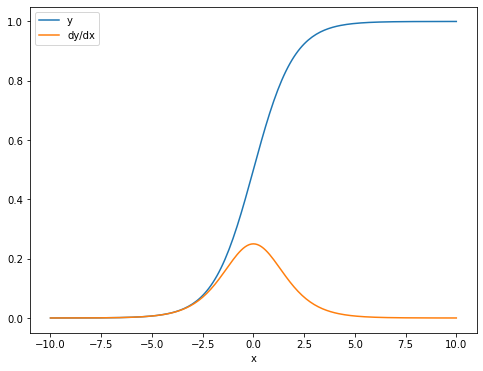

In [132]:
plt.plot(x.numpy(), y, label='y')
plt.plot(x.numpy(), dy_dx, label='dy/dx')
plt.legend()
_ = plt.xlabel('x')

#### 张量源

In [137]:
x = tf.random.normal([7, 5])
layer = tf.keras.layers.Dense(10, activation=tf.nn.relu)

with tf.GradientTape(persistent=True) as tape:
  y = layer(x)

print("y.shape=", y.shape)
print("layer.kernel.shape=", layer.kernel.shape)

j = tape.jacobian(y, layer.kernel)
print("雅可比矩阵形状", j.shape, type(j))

y.shape= (7, 10)
layer.kernel.shape= (5, 10)
雅可比矩阵形状 (7, 10, 5, 10) <class 'tensorflow.python.framework.ops.EagerTensor'>


In [140]:
# 在目标的维度上求和，会得到由 GradientTape.gradient 计算的总和的梯度。
g = tape.gradient(y, layer.kernel)
print('g.shape:', g.shape)

j_sum = tf.reduce_sum(j, axis=[0, 1])
delta = tf.reduce_max(abs(g - j_sum)).numpy()
assert delta < 1e-3
print('delta:', delta)

g.shape: (5, 10)
delta: 4.7683716e-07


### 黑塞矩阵举例
虽然 tf.GradientTape 并没有给出构造黑塞矩阵的显式方法，但可以使用 GradientTape.jacobian 方法进行构建

> 黑塞矩阵包含 N**2 个参数。由于这个原因和其他原因，它对于大多数模型都不实际

此示例主要是为了演示如何使用 GradientTape.jacobian 方法，并不是对直接黑塞矩阵优化的认可。黑塞矩阵向量积可以通过嵌套条带有效计算，这也是一种更有效的二阶优化方法。

In [142]:
x = tf.random.normal([7, 5])
layer1 = tf.keras.layers.Dense(8, activation=tf.nn.relu)
layer2 = tf.keras.layers.Dense(6, activation=tf.nn.relu)

with tf.GradientTape() as t2:
  with tf.GradientTape() as t1:
    x = layer1(x)
    x = layer2(x)
    loss = tf.reduce_mean(x**2)

  g = t1.gradient(loss, layer1.kernel)

h = t2.jacobian(g, layer1.kernel)

print(f'layer.kernel.shape: {layer1.kernel.shape}')
print(f'h.shape: {h.shape}')

layer.kernel.shape: (5, 8)
h.shape: (5, 8, 5, 8)


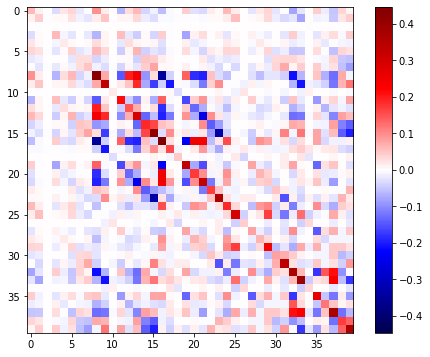

In [144]:
# 要将此黑塞矩阵用于牛顿方法步骤，首先需要将其轴展平为矩阵，然后将梯度展平为向量
n_params = tf.reduce_prod(layer1.kernel.shape)

g_vec = tf.reshape(g, [n_params, 1])
h_mat = tf.reshape(h, [n_params, n_params])

# 黑塞矩阵应当对称
def imshow_zero_center(image, **kwargs):
  lim = tf.reduce_max(abs(image))
  plt.imshow(image, vmin=-lim, vmax=lim, cmap='seismic', **kwargs)
  plt.colorbar()

imshow_zero_center(h_mat)

In [145]:
# 牛顿方法更新步骤如下
eps = 1e-3
eye_eps = tf.eye(h_mat.shape[0])*eps

# 注：实际上不反转矩阵
# X(k+1) = X(k) - (∇²f(X(k)))^-1 @ ∇f(X(k))
# h_mat = ∇²f(X(k))
# g_vec = ∇f(X(k))
update = tf.linalg.solve(h_mat + eye_eps, g_vec)

# Reshape the update and apply it to the variable.
_ = layer1.kernel.assign_sub(tf.reshape(update, layer1.kernel.shape))

### 批量雅可比矩阵 @TODO

## 图形与函数简介
本指南深入研究TensorFlow和Keras的surface，以了解TensorFlow的工作原理。如果您想立即开始使用Keras，请参阅我们的[Keras指南集合](https://tensorflow.google.cn/guide/keras?hl=zh_cn)

在本指南中，您将看到TensorFlow如何允许您对代码进行简单更改以获取图形，如何存储和表示图形以及如何使用它们来加速和导出模型的核心。

想细节介绍请看：[tf.function指南](https://tensorflow.google.cn/guide/function?hl=zh_cn)

### 什么是图
python的op-by-op模式（即可执行模式）阻止了大量的可用加速。**如果可以从Python提取张量计算，则可以将它们制成图**。

图包含2部分：
- **tf.Operation对象的数据结构，代表计算单位**
- **tf.Tensor对象，代表操作之间流动的数据单位**

它们是在tf.Graph上下文中定义的。由于这些图是数据结构，因此无需原始Python代码就可以保存，运行和还原它们。

可以在tensorboard中可视化

### The benefits of graphs
- 灵活性：没有python环境也可以使用（移动环境，嵌入式和后端服务器），python导出模型时，以图的format来保存。
- 容易优化
    - 通过折叠计算中的常数节点来静态推断张量的值（“常数折叠”）
    - 独立的计算子部分，可以在线程或设备之间进行拆分
    - 通过消除常见的子表达式来简化算术运算

简而言之，图形非常有用，它可以使TensorFlow快速运行，并行运行并在多个设备上高效运行。

但是，为了方便起见，您仍然想在Python中定义我们的机器学习模型（或其他计算），然后在需要时自动构造图。

### 追踪图
创建图：tf.function作为装饰器

In [17]:
# Define a Python function
def function_to_get_faster(x, y, b):
  x = tf.matmul(x, y)
  x = x + b
  return x

# Create a `Function` object that contains a graph
a_function_that_uses_a_graph = tf.function(function_to_get_faster)

# Make some tensors
x1 = tf.constant([[1.0, 2.0]])
y1 = tf.constant([[2.0], [3.0]])
b1 = tf.constant(4.0)

# It just works!
a_function_that_uses_a_graph(x1, y1, b1).numpy()

array([[12.]], dtype=float32)

### Flow control and side effect

tf.autograph默认的方式，流控制和循环会转换为TensorFlow。Autograph使用多种方法的组合，包括标准化循环结构，展开和AST操作。

下面的例子，展示了autograph可以转换if-then，loop，break等语句。

In [9]:
def my_function(x):
  if tf.reduce_sum(x) <= 1:
    return x * x
  else:
    return x-1

a_function = tf.function(my_function)

print("First branch, with graph:", a_function(tf.constant(1.0)).numpy())
print("Second branch, with graph:", a_function(tf.constant([5.0, 5.0])).numpy())

First branch, with graph: 1.0
Second branch, with graph: [4. 4.]


In [10]:
# Don't read the output too carefully.
print(tf.autograph.to_code(my_function))

def tf__my_function(x):
    with ag__.FunctionScope('my_function', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()

        def get_state():
            return (retval_, do_return)

        def set_state(vars_):
            nonlocal retval_, do_return
            (retval_, do_return) = vars_

        def if_body():
            nonlocal retval_, do_return
            try:
                do_return = True
                retval_ = (ag__.ld(x) * ag__.ld(x))
            except:
                do_return = False
                raise

        def else_body():
            nonlocal retval_, do_return
            try:
                do_return = True
                retval_ = (ag__.ld(x) - 1)
            except:
                do_return = False
                raise
        ag__.if_stmt((ag__.converted_call(ag__.ld(tf).reduce_sum, (ag

### 提速
仅仅用tf.function进行wrap，并不会自动加快代码速度。对于单个计算上多次调用的小函数，调用图或图形片段的开销可能会占主导。而对于已经在加速器上进行的运算，如GPU的卷积堆栈，加速也不会很大

但是，**对于复杂的计算，图形可以显著提升速度：图减少了python与设备之间的通信而加快了速度。在运行许多小层时，加速最明显**

In [11]:
# Create an oveerride model to classify pictures
class SequentialModel(tf.keras.Model):
  def __init__(self, **kwargs):
    super(SequentialModel, self).__init__(**kwargs)
    self.flatten = tf.keras.layers.Flatten(input_shape=(28, 28))
    # Add a lot of small layers
    num_layers = 100
    self.my_layers = [tf.keras.layers.Dense(64, activation="relu")
                      for n in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(0.2)
    self.dense_2 = tf.keras.layers.Dense(10)

  def call(self, x):
    x = self.flatten(x)
    for layer in self.my_layers:
      x = layer(x)
    x = self.dropout(x)
    x = self.dense_2(x)
    return x

In [14]:
input_data = tf.random.uniform([20, 28, 28])

In [15]:
eager_model = SequentialModel()

# Don't count the time for the initial build.
eager_model(input_data)
print("Eager time:", timeit.timeit(lambda: eager_model(input_data), number=100))

Eager time: 0.9424598870100453


In [16]:
# Wrap the call method in a `tf.function`
graph_model = SequentialModel()
graph_model.call = tf.function(graph_model.call)

# Don't count the time for the initial build and trace.
graph_model(input_data)
print("Graph time:", timeit.timeit(lambda: graph_model(input_data), number=100))

Graph time: 0.2501833110000007


### 多态函数
当我们跟踪函数时，创建的Function对象是多态的。

每一次在不同的dtypes形状上使用，都会创建一个tf.Graph（对应一个concrete_function）。再遇到同样dtypes，则直接调用预先存储的图

从概念上讲：
- 一个tf.Graph，是描述一个计算的原始的可移植的数据结构
- 一个Function是ConcreteFunctions上的缓存，跟踪，调度程序
- A ConcreteFunction是图的eager-compatible wrapper，可让您从Python执行图

### 检查多态函数
如上一节中的a_function,是调用Python上的函数my_function之上的tf.function的结果

In [18]:
print(a_function)

print("Calling a `Function`:")
print("Int:", a_function(tf.constant(2)))
print("Float:", a_function(tf.constant(2.0)))
print("Rank-1 tensor of floats", a_function(tf.constant([2.0, 2.0, 2.0])))

Calling a `Function`:
Int: tf.Tensor(1, shape=(), dtype=int32)
Float: tf.Tensor(1.0, shape=(), dtype=float32)
Rank-1 tensor of floats tf.Tensor([1. 1. 1.], shape=(3,), dtype=float32)


In [19]:
# Get the concrete function that works on floats
print("Inspecting concrete functions")
print("Concrete function for float:")
print(a_function.get_concrete_function(tf.TensorSpec(shape=[], dtype=tf.float32)))
print("Concrete function for tensor of floats:")
print(a_function.get_concrete_function(tf.constant([2.0, 2.0, 2.0])))

Inspecting concrete functions
Concrete function for float:
ConcreteFunction my_function(x)
  Args:
    x: float32 Tensor, shape=()
  Returns:
    float32 Tensor, shape=()
Concrete function for tensor of floats:
ConcreteFunction my_function(x)
  Args:
    x: float32 Tensor, shape=(3,)
  Returns:
    float32 Tensor, shape=(3,)


In [20]:
# Concrete functions are callable
# Note: You won't normally do this, but instead just call the containing `Function`
cf = a_function.get_concrete_function(tf.constant(2))
print("Directly calling a concrete function:", cf(tf.constant(2)))

Directly calling a concrete function: tf.Tensor(1, shape=(), dtype=int32)


### Reverting to eager execution
以上更偏底层，调试使用eage execution相对容易。

您可以通过以下方法确保自己即可执行：
- Call models and layers directly as callables
- When using Keras compile/fit, at compile time use model.compile(run_eagerly=True)
- Set global execution mode via tf.config.run_functions_eagerly(True)

#### Using run_eagerly=True

In [22]:
# Define an identity layer with an eager side effect
class EagerLayer(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super(EagerLayer, self).__init__(**kwargs)
    # Do some kind of initialization here

  def call(self, inputs):
    print("\nCurrently running eagerly", str(datetime.now()))
    return inputs

# Create an override model to classify pictures, adding the custom layer
class SequentialModel(tf.keras.Model):
  def __init__(self):
    super(SequentialModel, self).__init__()
    self.flatten = tf.keras.layers.Flatten(input_shape=(28, 28))
    self.dense_1 = tf.keras.layers.Dense(128, activation="relu")
    self.dropout = tf.keras.layers.Dropout(0.2)
    self.dense_2 = tf.keras.layers.Dense(10)
    self.eager = EagerLayer()

  def call(self, x):
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.dropout(x)
    x = self.dense_2(x)
    return self.eager(x)

# Create an instance of this model
model = SequentialModel()

# Generate some nonsense pictures and labels
input_data = tf.random.uniform([60, 28, 28])
labels = tf.random.uniform([60])

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

首先，以非eager模式编译，此时，模型未trace（尽管有他的名字--没看懂），编译仅设置损失函数，优化与其他参数


In [23]:
model.compile(run_eagerly=False, loss=loss_fn)

现在，调用fit并查看该函数已被跟踪（两次），然后eager的效果没有再有----@TODO没有看懂，后续看完那再来

In [24]:
model.fit(input_data, labels, epochs=3)

Epoch 1/3

Currently running eagerly 2020-12-22 23:45:02.689531

Currently running eagerly 2020-12-22 23:45:02.763193
2/2 [==============================] - 0s 1ms/step - loss: 1.3927
Epoch 2/3
2/2 [==============================] - 0s 965us/step - loss: 0.0034
Epoch 3/3
2/2 [==============================] - 0s 865us/step - loss: 0.0011


但是，如果eager地运行一个epochs，就会看到两次eager的副作用。

In [25]:
print("Running eagerly")
# When compiling the model, set it to run eagerly
model.compile(run_eagerly=True, loss=loss_fn)

model.fit(input_data, labels, epochs=1)

Running eagerly

Currently running eagerly 2020-12-22 23:47:20.408322
1/2 [==============>...............] - ETA: 0s - loss: 0.0015
Currently running eagerly 2020-12-22 23:47:20.420201
2/2 [==============================] - 0s 3ms/step - loss: 7.8982e-04


#### Using run_functions_eagerly
还可以全局设置所有内容以使其热切运行。这是一个绕过多态函数的跟踪函数并直接调用原始函数的开关。可以使用它进行调试

In [26]:
# Now, globally set everything to run eagerly
tf.config.run_functions_eagerly(True)
print("Run all functions eagerly.")

# Create a polymorphic function
polymorphic_function = tf.function(model)

print("Tracing")
# This does, in fact, trace the function
print(polymorphic_function.get_concrete_function(input_data))

print("\nCalling twice eagerly")
# When you run the function again, you will see the side effect
# twice, as the function is running eagerly.
result = polymorphic_function(input_data)
result = polymorphic_function(input_data)

Run all functions eagerly.
Tracing

Currently running eagerly 2020-12-22 23:52:44.940157
ConcreteFunction function(self)
  Args:
    self: float32 Tensor, shape=(60, 28, 28)
  Returns:
    float32 Tensor, shape=(60, 10)

Calling twice eagerly

Currently running eagerly 2020-12-22 23:52:44.955996

Currently running eagerly 2020-12-22 23:52:44.956798


In [27]:
# Don't forget to set it back when you are done
tf.config.experimental_run_functions_eagerly(False)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


### Tracing and performance

trace会影响性能

参考：[Better performance with tf.function](https://tensorflow.google.cn/guide/function?hl=zh_cn#when_to_retrace)

## 模块，层和模型简介
大多数模型是由图层组成的。层是具有已知数学结构的函数，可以重复使用并具有可训练的变量。在TensorFlow中，大多数层和模型的高层实现（例如Keras或Sonnet）都建立在相同的基础类上：tf.Module。

In [28]:
class SimpleModule(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.a_variable = tf.Variable(5.0, name="train_me")
    self.non_trainable_variable = tf.Variable(5.0, trainable=False, name="do_not_train_me")
  def __call__(self, x):
    return self.a_variable * x + self.non_trainable_variable

simple_module = SimpleModule(name="simple")

simple_module(tf.constant(5.0))

<tf.Tensor: shape=(), dtype=float32, numpy=30.0>

\_\_call\_\_ 除了充当可调用的Python之外，没有什么特别的。可以使用任意功能调用模型。

可以出于任何原因设置变量的可训练性，包括冻结微调过程中的层和变量

注意：“tf.Module是两者的基类tf.keras.layers.Layer，tf.keras.Model因此您在此处看到的所有内容也适用于Keras。出于历史兼容性的原因，Keras层不会从模块中收集变量，因此您的模型应仅使用模块或仅使用Keras层。但是，以下检查变量的方法在二者中是相同的。

通过继承tf.Module，任何tf.Variable或tf.Module分配给该对象的属性实例自动收集。这使您可以保存和加载变量，还可以创建tf.Module集合。

In [29]:
# All trainable variables
print("trainable variables:", simple_module.trainable_variables)
# Every variable
print("all variables:", simple_module.variables)

trainable variables: (<tf.Variable 'train_me:0' shape=() dtype=float32, numpy=5.0>,)
all variables: (<tf.Variable 'train_me:0' shape=() dtype=float32, numpy=5.0>, <tf.Variable 'do_not_train_me:0' shape=() dtype=float32, numpy=5.0>)


以下是个示例：

In [30]:
# 首先，是一个dense(线性)层：
class Dense(tf.Module):
  def __init__(self, in_features, out_features, name=None):
    super().__init__(name=name)
    self.w = tf.Variable(
      tf.random.normal([in_features, out_features]), name='w')
    self.b = tf.Variable(tf.zeros([out_features]), name='b')
  def __call__(self, x):
    y = tf.matmul(x, self.w) + self.b
    return tf.nn.relu(y)
# 然后是完整的模型，该模型将创建两个图层实例并应用它们。
class SequentialModule(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)

    self.dense_1 = Dense(in_features=3, out_features=3)
    self.dense_2 = Dense(in_features=3, out_features=2)

  def __call__(self, x):
    x = self.dense_1(x)
    return self.dense_2(x)

# You have made a model!
my_model = SequentialModule(name="the_model")

# Call it, with random results
print("Model results:", my_model(tf.constant([[2.0, 2.0, 2.0]])))

Model results: tf.Tensor([[0. 0.]], shape=(1, 2), dtype=float32)


tf.Module实例会自动，递归的收集任何分配给他的tf.Variable或tf.Module实例。这使您可以tf.Module使用单个模型实例管理的集合，并保存和加载整个模型。

In [33]:
print("Submodules:", my_model.submodules)

Submodules: (<__main__.Dense object at 0x7f4464346ed0>, <__main__.Dense object at 0x7f447c6dbd50>)


In [34]:
for var in my_model.variables:
  print(var, "\n")

<tf.Variable 'b:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)> 

<tf.Variable 'w:0' shape=(3, 3) dtype=float32, numpy=
array([[ 0.66921806, -0.4397519 , -0.29343274],
       [ 1.6957233 , -0.21541229,  1.2884734 ],
       [-1.8990558 , -0.65643877, -0.43678993]], dtype=float32)> 

<tf.Variable 'b:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)> 

<tf.Variable 'w:0' shape=(3, 2) dtype=float32, numpy=
array([[-1.0837104 ,  0.6036416 ],
       [ 1.3044809 ,  0.04702454],
       [ 0.2647526 , -0.698534  ]], dtype=float32)> 



### Waiting to create variables

可以推迟到首次使用特定输入形状是才创建变量，不需要输入shape

In [39]:
class FlexibleDenseModule(tf.Module):
  # Note: No need for `in+features`
  def __init__(self, out_features, name=None):
    super().__init__(name=name)
    self.is_built = False
    self.out_features = out_features

  def __call__(self, x):
    # Create variables on first call.
    if not self.is_built:
      self.w = tf.Variable(
        tf.random.normal([x.shape[-1], self.out_features]), name='w')
      self.b = tf.Variable(tf.zeros([self.out_features]), name='b')
      self.is_built = True

    y = tf.matmul(x, self.w) + self.b
    return tf.nn.relu(y)

# Used in a module
class MySequentialModule(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)

    self.dense_1 = FlexibleDenseModule(out_features=3)
    self.dense_2 = FlexibleDenseModule(out_features=2)

  def __call__(self, x):
    x = self.dense_1(x)
    return self.dense_2(x)

my_model = MySequentialModule(name="the_model")
print("Model results:", my_model(tf.constant([[2.0, 2.0, 2.0]])))

Model results: tf.Tensor([[0. 0.]], shape=(1, 2), dtype=float32)


这种灵活性是为什么TensorFlow层通常只需要指定其输出的形状，例如tf.keras.layers.Dense，而不是输入和输出大小的原因

### 保存权重
使用checkpoint与SavedModel保存一个tf.Module

检查点只是权重（即模块及其子模块内部的变量集的值），检查点由两种文件组成-数据本身，然后是元数据的索引文件。索引文件跟踪实际保存的内容和检查点的编号，而检查点数据包含变量值及其属性查找路径。

In [40]:
chkp_path = "../learnMLData/my_checkpoint"
checkpoint = tf.train.Checkpoint(model=my_model)
checkpoint.write(chkp_path)
checkpoint.write(chkp_path)

'../learnMLData/my_checkpoint'

In [43]:
!ls ../learnMLData/my_checkpoint*
# 您可以查看一个检查点，以确保保存了所有变量集，并按包含变量的Python对象对其进行了排序。
tf.train.list_variables(chkp_path)

../learnMLData/my_checkpoint.data-00000-of-00001
../learnMLData/my_checkpoint.index


[('_CHECKPOINTABLE_OBJECT_GRAPH', []),
 ('model/dense_1/b/.ATTRIBUTES/VARIABLE_VALUE', [3]),
 ('model/dense_1/w/.ATTRIBUTES/VARIABLE_VALUE', [3, 3]),
 ('model/dense_2/b/.ATTRIBUTES/VARIABLE_VALUE', [2]),
 ('model/dense_2/w/.ATTRIBUTES/VARIABLE_VALUE', [3, 2])]

分布式训练时，他们可以被共享，这就是为什么他们被编码。

重新加载模型时，将覆盖Python对象的值：

In [46]:
new_model = MySequentialModule()
new_checkpoint = tf.train.Checkpoint(model=new_model)
new_checkpoint.restore(chkp_path)

# Should be the same result as above
new_model(tf.constant([[2.0, 2.0, 2.0]]))

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0., 0.]], dtype=float32)>

注意：由于检查点是长时间培训工作流的核心，因此它tf.checkpoint.CheckpointManager是一个帮助程序类，它使检查点管理更加容易。有关更多详细信息，请参见[训练检查点](https://www.tensorflow.org/guide/checkpoint?hl=zh_cn)。

### Saving functions
TensorFlow可以运行没有原始Python对象的模型，如TensorFlow Serving和TensorFlow Lite中所见，甚至当您从TensorFlow Hub下载经过训练的模型时也是如此。

TensorFlow需要知道如何执行Python中描述的计算，但是**没有原始代码**。为此，您可以制作一个**图形**，该图包含实现该功能的**操作或ops**。

可以在上面的模型中通过添加@tf.function装饰器来定义图，以指示此代码应作为图运行

In [48]:
class MySequentialModule(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)

    self.dense_1 = Dense(in_features=3, out_features=3)
    self.dense_2 = Dense(in_features=3, out_features=2)
  # 定义图
  @tf.function
  def __call__(self, x):
    x = self.dense_1(x)
    return self.dense_2(x)

# You have made a model with a graph!
my_model = MySequentialModule(name="the_model")
print(my_model([[2.0, 2.0, 2.0]]))
print(my_model([[[2.0, 2.0, 2.0], [2.0, 2.0, 2.0]]]))

tf.Tensor([[1.0824299 0.       ]], shape=(1, 2), dtype=float32)
tf.Tensor(
[[[1.0824299 0.       ]
  [1.0824299 0.       ]]], shape=(1, 2, 2), dtype=float32)


In [49]:
# Set up logging.
stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = "../learnMLData/func/%s" % stamp
writer = tf.summary.create_file_writer(logdir)

# Create a new model to get a fresh trace
# Otherwise the summary will not see the graph.
new_model = MySequentialModule()

# Bracket the function call with
# tf.summary.trace_on() and tf.summary.trace_export().
tf.summary.trace_on(graph=True)
tf.profiler.experimental.start(logdir)
# Call only one tf.function when tracing.
z = print(new_model(tf.constant([[2.0, 2.0, 2.0]])))
with writer.as_default():
  tf.summary.trace_export(
      name="my_func_trace",
      step=0,
      profiler_outdir=logdir)

tf.Tensor([[0.87751096 0.        ]], shape=(1, 2), dtype=float32)
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


In [56]:
%tensorboard --logdir "../learnMLData/func"

Reusing TensorBoard on port 6006 (pid 579432), started 0:01:20 ago. (Use '!kill 579432' to kill it.)

### Creating a SavedModel


In [57]:
tf.saved_model.save(my_model, "../learnMLData/the_saved_model")

INFO:tensorflow:Assets written to: ../learnMLData/the_saved_model/assets


In [59]:
%ls -l ../learnMLData/the_saved_model

总用量 24
drwxr-xr-x 2 hdw hdw  4096 12月 23 19:55 assets/
-rw-rw-r-- 1 hdw hdw 12637 12月 23 19:55 saved_model.pb
drwxr-xr-x 2 hdw hdw  4096 12月 23 19:55 variables/


saved_model.pb:描述的是functional tf.Graph的协议缓冲区

可以从此表示形式加载模型和图层，而无需实际创建创建它的类的实例。

In [60]:
new_model = tf.saved_model.load("../learnMLData/the_saved_model")

new_model通过加载保存的模型创建的，是内部TensorFlow用户对象，无需任何类知识。它不是类型SequentialModule

In [61]:
isinstance(new_model, SequentialModule)

False

此新模型​​适用于已定义的输入签名。您不能向这样还原的模型添加更多签名

因此，使用SavedModel，您可以使用来保存TensorFlow权重和图形tf.Module，然后再次加载它们。

In [62]:
print(my_model([[2.0, 2.0, 2.0]]))
print(my_model([[[2.0, 2.0, 2.0], [2.0, 2.0, 2.0]]]))

tf.Tensor([[1.0824299 0.       ]], shape=(1, 2), dtype=float32)
tf.Tensor(
[[[1.0824299 0.       ]
  [1.0824299 0.       ]]], shape=(1, 2, 2), dtype=float32)


### Keras models and layers
keras上的tf.Module
#### Keras layers
tf.keras.layers.Layer是所有Keras图层的基类，并且继承自tf.Module。

将模型转换为Keras，只需要将基类转换为tf.keras.layers.Layer，并且将\_\_call\_\_变为call

In [63]:
class MyDense(tf.keras.layers.Layer):
  # Adding **kwargs to support base Keras layer arguemnts
  def __init__(self, in_features, out_features, **kwargs):
    super().__init__(**kwargs)

    # This will soon move to the build step; see below
    self.w = tf.Variable(
      tf.random.normal([in_features, out_features]), name='w')
    self.b = tf.Variable(tf.zeros([out_features]), name='b')
  def call(self, x):
    y = tf.matmul(x, self.w) + self.b
    return tf.nn.relu(y)

simple_layer = MyDense(name="simple", in_features=3, out_features=3)

Keras层有他自己的\_\_call\_\_,做一下bookkeeping，然后调用call().

In [64]:
simple_layer([[2.0, 2.0, 2.0]])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[4.0551176, 3.303404 , 1.2823098]], dtype=float32)>

### The build step
包含一个build方法，更加灵活的定义图层，近被调用一次，并以输入图层的形状进行调用。**通常用于创建变量（weights）**

In [68]:
class FlexibleDense(tf.keras.layers.Layer):
  # Note the added `**kwargs`, as Keras supports many arguments
  def __init__(self, out_features, **kwargs):
    super().__init__(**kwargs)
    self.out_features = out_features

  def build(self, input_shape):  # Create the state of the layer (weights)
    self.w = tf.Variable(
      tf.random.normal([input_shape[-1], self.out_features]), name='w')
    self.b = tf.Variable(tf.zeros([self.out_features]), name='b')

  def call(self, inputs):  # Defines the computation from inputs to outputs
    return tf.matmul(inputs, self.w) + self.b

# Create the instance of the layer
flexible_dense = FlexibleDense(out_features=3)


In [69]:
# 此时model未build，所以没有变量
flexible_dense.variables

[]

In [74]:
#调用函数，分配适当大小的变量
# Call it, with predictably random results
print("Model results:", flexible_dense(tf.constant([[2.0, 2.0, 2.0], [3.0, 3.0, 3.0]])))

flexible_dense.variables

Model results: tf.Tensor(
[[-4.3014574  -5.2646375  -0.44863436]
 [-6.4521866  -7.8969564  -0.6729516 ]], shape=(2, 3), dtype=float32)


[<tf.Variable 'flexible_dense_2/w:0' shape=(3, 3) dtype=float32, numpy=
 array([[-1.0131483 , -0.8543303 ,  0.65977806],
        [-0.5885917 , -2.3330863 , -0.71481997],
        [-0.54898876,  0.5550979 , -0.16927527]], dtype=float32)>,
 <tf.Variable 'flexible_dense_2/b:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]

由于build仅被调用一次，如果输入形状与图层变量不兼容，则输入将被拒绝。

In [75]:
try:
  print("Model results:", flexible_dense(tf.constant([[2.0, 2.0, 2.0, 2.0]])))
except tf.errors.InvalidArgumentError as e:
  print("Failed:", e)

Failed: Matrix size-incompatible: In[0]: [1,4], In[1]: [3,3] [Op:MatMul]


Keras图层具有许多其他功能，包括：

- 可选损失
- 支持指标
- 内置支持可选training参数以区分训练和推理（inference）使用
- get_config和from_config方法，可让您准确地存储配置以允许在Python中克隆模型

### Keras models
我们可以定义嵌套的Keras layers模型。

Keras提供了一个full-featured的模型类，tf.keras.Model，继承自tf.keras.layera.Layer

因此Keras模型是Keras图层，可以以相同的方式使用，嵌套和保存。Keras模型具有额外的功能，使它们易于在多台机器上进行训练，评估，加载，保存甚至训练

In [79]:
class MySequentialModel(tf.keras.Model):
  def __init__(self, name=None, **kwargs):
    super().__init__(**kwargs)

    self.dense_1 = FlexibleDense(out_features=3)
    self.dense_2 = FlexibleDense(out_features=2)
  def call(self, x):
    x = self.dense_1(x)
    return self.dense_2(x)

# You have made a Keras model!
my_sequential_model = MySequentialModel(name="the_model")

# Call it on a tensor, with random results
print("Model results:", my_sequential_model(tf.constant([[2.0, 2.0, 2.0]])))

Model results: tf.Tensor([[-5.068058  -1.3163732]], shape=(1, 2), dtype=float32)


注意：为了强调上面的注释，tf.Module嵌套在Keras图层或模型中的原始对象不会收集其用于训练或保存的变量。而是在Keras层内部嵌套Keras层。

In [80]:
my_sequential_model.submodules

(<__main__.FlexibleDense at 0x7f446431c3d0>,
 <__main__.FlexibleDense at 0x7f44645c3650>)

overriding tf.keras.Model是构建TensorFlow模型的非常Python化的方法。如果要从其他框架迁移模型，这可能非常简单。

如果要构建的模型是现有图层和输入的简单组合，则可以使用 [functional API](https://www.tensorflow.org/guide/keras/functional?hl=zh_cn)节省时间和空间，该功能性API附带了有关模型重构和体系结构的其他功能。

In [81]:
inputs = tf.keras.Input(shape=[3,])

x = FlexibleDense(3)(inputs)
x = FlexibleDense(2)(x)

my_functional_model = tf.keras.Model(inputs=inputs, outputs=x)

my_functional_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
flexible_dense_11 (FlexibleD (None, 3)                 12        
_________________________________________________________________
flexible_dense_12 (FlexibleD (None, 2)                 8         
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


### Saving Keras models
Keras模型也可以被checkpoint，也可以使用tf.saved_models.save()保存，Keras模型具有便捷的方法和其他功能。

In [82]:
my_sequential_model.save("../learnMLData/exname_of_file")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../learnMLData/exname_of_file/assets


In [84]:
reconstructed_model = tf.keras.models.load_model("../learnMLData/exname_of_file")

KerasSavedModels还可以保存metric, loss, optimizer状态。

In [85]:
reconstructed_model(tf.constant([[2.0, 2.0, 2.0]]))

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-5.068058 , -1.3163732]], dtype=float32)>

## Basic training loops
### Data
张量表示数据可以与加速器与矢量化计算配合使用。

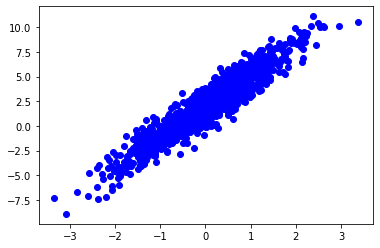

In [86]:
# The actual line
TRUE_W = 3.0
TRUE_B = 2.0

NUM_EXAMPLES = 1000

# A vector of random x values
x = tf.random.normal(shape=[NUM_EXAMPLES])

# Generate some noise
noise = tf.random.normal(shape=[NUM_EXAMPLES])

# Calculate y
y = x * TRUE_W + TRUE_B + noise

# Plot all the data
import matplotlib.pyplot as plt

plt.scatter(x, y, c="b")
plt.show()

### 定义模型
tf.Variable：表示模型中的所有变量

tf.Module：封装变量与计算


In [90]:
class MyModel(tf.Module):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    # Initialize the weights to `5.0` and the bias to `0.0`
    # In practice, these should be randomly initialized
    self.w = tf.Variable(5.0)
    self.b = tf.Variable(0.0)

  def __call__(self, x):
    return self.w * x + self.b

model = MyModel()

# List the variables tf.modules's built-in variable aggregation.
print("Variables:", model.variables)

# Verify the model works
assert model(3.0).numpy() == 15.0

Variables: (<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=5.0>)


### 定义loss function

训练之前，根据MyModel中初始化的参数，画出初始图

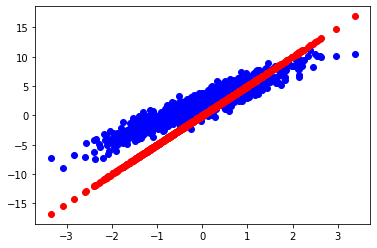

Current loss: 8.645920


In [93]:
# This computes a single loss value for an entire batch
def loss(target_y, predicted_y):
  return tf.reduce_mean(tf.square(target_y - predicted_y))

plt.scatter(x, y, c="b")
plt.scatter(x, model(x), c="r")
plt.show()

print("Current loss: %1.6f" % loss(model(x), y).numpy())

### 定义training loop
顺序重复执行三个任务：
1. batch输入
2. 计算损失函数
3. 使用gradient tab去find gradients
4. 使用上述梯度优化变量

Epoch  0: W=4.61 b=0.39, loss=5.93752
Starting: W=4.61 b=0.39, loss=5.93752
Epoch  1: W=4.31 b=0.70, loss=4.19888
Starting: W=4.31 b=0.70, loss=4.19888
Epoch  2: W=4.06 b=0.95, loss=3.08277
Starting: W=4.06 b=0.95, loss=3.08277
Epoch  3: W=3.86 b=1.16, loss=2.36630
Starting: W=3.86 b=1.16, loss=2.36630
Epoch  4: W=3.70 b=1.32, loss=1.90635
Starting: W=3.70 b=1.32, loss=1.90635
Epoch  5: W=3.58 b=1.45, loss=1.61110
Starting: W=3.58 b=1.45, loss=1.61110
Epoch  6: W=3.48 b=1.55, loss=1.42156
Starting: W=3.48 b=1.55, loss=1.42156
Epoch  7: W=3.39 b=1.63, loss=1.29988
Starting: W=3.39 b=1.63, loss=1.29988
Epoch  8: W=3.33 b=1.70, loss=1.22177
Starting: W=3.33 b=1.70, loss=1.22177
Epoch  9: W=3.28 b=1.75, loss=1.17163
Starting: W=3.28 b=1.75, loss=1.17163


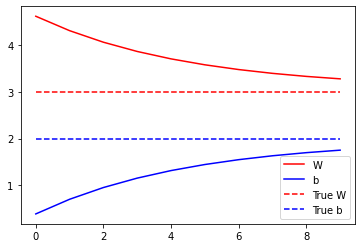

In [96]:
# Given a callable model, inputs, outputs, and a learning rate...
def train(model, x, y, learning_rate):

  with tf.GradientTape() as t:
    # Trainable variables are automatically tracked by GradientTape
    current_loss = loss(y, model(x))

  # Use GradientTape to calculate the gradients with respect to W and b
  dw, db = t.gradient(current_loss, [model.w, model.b])

  # Subtract the gradient scaled by the learning rate
  model.w.assign_sub(learning_rate * dw)
  model.b.assign_sub(learning_rate * db)

model = MyModel()

# Collect the history of W-values and b-values to plot later
Ws, bs = [], []
epochs = range(10)

# Define a training loop
def training_loop(model, x, y):

  for epoch in epochs:
    # Update the model with the single giant batch
    train(model, x, y, learning_rate=0.1)

    # Track this before I update
    Ws.append(model.w.numpy())
    bs.append(model.b.numpy())
    current_loss = loss(y, model(x))

    print("Epoch %2d: W=%1.2f b=%1.2f, loss=%2.5f" %
          (epoch, Ws[-1], bs[-1], current_loss))

    print("Starting: W=%1.2f b=%1.2f, loss=%2.5f" %
      (model.w, model.b, loss(y, model(x))))

# Do the training
training_loop(model, x, y)

# Plot it
plt.plot(epochs, Ws, "r",
         epochs, bs, "b")

plt.plot([TRUE_W] * len(epochs), "r--",
         [TRUE_B] * len(epochs), "b--")

plt.legend(["W", "b", "True W", "True b"])
plt.show()

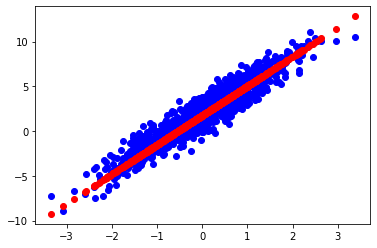

Current loss: 1.171632


In [97]:
# Visualize how the trained model performs
plt.scatter(x, y, c="b")
plt.scatter(x, model(x), c="r")
plt.show()

print("Current loss: %1.6f" % loss(model(x), y).numpy())

### 使用Keras

In [98]:
class MyModelKeras(tf.keras.Model):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    # Initialize the weights to `5.0` and the bias to `0.0`
    # In practice, these should be randomly initialized
    self.w = tf.Variable(5.0)
    self.b = tf.Variable(0.0)

  def __call__(self, x, **kwargs):
    return self.w * x + self.b

keras_model = MyModelKeras()

# Reuse the training loop with a Keras model
training_loop(keras_model, x, y)

# You can also save a checkpoint using Keras's built-in support
keras_model.save_weights("../learnMLData/my_checkpoint")

Epoch  0: W=4.61 b=0.39, loss=5.93752
Starting: W=4.61 b=0.39, loss=5.93752
Epoch  1: W=4.31 b=0.70, loss=4.19888
Starting: W=4.31 b=0.70, loss=4.19888
Epoch  2: W=4.06 b=0.95, loss=3.08277
Starting: W=4.06 b=0.95, loss=3.08277
Epoch  3: W=3.86 b=1.16, loss=2.36630
Starting: W=3.86 b=1.16, loss=2.36630
Epoch  4: W=3.70 b=1.32, loss=1.90635
Starting: W=3.70 b=1.32, loss=1.90635
Epoch  5: W=3.58 b=1.45, loss=1.61110
Starting: W=3.58 b=1.45, loss=1.61110
Epoch  6: W=3.48 b=1.55, loss=1.42156
Starting: W=3.48 b=1.55, loss=1.42156
Epoch  7: W=3.39 b=1.63, loss=1.29988
Starting: W=3.39 b=1.63, loss=1.29988
Epoch  8: W=3.33 b=1.70, loss=1.22177
Starting: W=3.33 b=1.70, loss=1.22177
Epoch  9: W=3.28 b=1.75, loss=1.17163
Starting: W=3.28 b=1.75, loss=1.17163


#### 使用内置功能

需要model.compile()来设置参数，用model.fit()训练，使用L2 loss与梯度下降

In [100]:
keras_model = MyModelKeras()

# compile sets the training paramaeters
keras_model.compile(
    # By default, fit() uses tf.function().  You can
    # turn that off for debugging, but it is on now.
    run_eagerly=False,

    # Using a built-in optimizer, configuring as an object
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),

    # Keras comes with built-in MSE error
    # However, you could use the loss function
    # defined above
    loss=tf.keras.losses.mean_squared_error,
)

Kerasfit希望将批处理数据或完整的数据集作为NumPy数组。NumPy数组分为多个批次，默认批次大小为32。

此处输入batch_size=1000是为了与上面对比是的epoch相同

In [101]:
print(x.shape[0])
keras_model.fit(x, y, epochs=10, batch_size=1000)

1000
Epoch 1/10
1/1 [==============================] - 0s 824us/step - loss: 8.6459
Epoch 2/10
1/1 [==============================] - 0s 521us/step - loss: 5.9375
Epoch 3/10
1/1 [==============================] - 0s 475us/step - loss: 4.1989
Epoch 4/10
1/1 [==============================] - 0s 462us/step - loss: 3.0828
Epoch 5/10
1/1 [==============================] - 0s 626us/step - loss: 2.3663
Epoch 6/10
1/1 [==============================] - 0s 587us/step - loss: 1.9064
Epoch 7/10
1/1 [==============================] - 0s 509us/step - loss: 1.6111
Epoch 8/10
1/1 [==============================] - 0s 568us/step - loss: 1.4216
Epoch 9/10
1/1 [==============================] - 0s 486us/step - loss: 1.2999
Epoch 10/10
1/1 [==============================] - 0s 526us/step - loss: 1.2218


### 模型构建方法
https://www.tensorflow.org/js/guide/models_and_layers?hl=zh-cn

1. 用 Layers API（用 layers 来创建模型）：sequential model
2. 用 Core API（底端算子，例如 tf.matMul()或tf.add()等）来建立模型

# tensorboard使用

TensorBoard 是一种可视化工具，用于了解、调试和优化模型训练过程。它使用在执行程序时编写的摘要事件。

您可以在 Eager Execution 中使用 tf.summary 记录变量摘要。例如，要每 100 个训练步骤记录一次 loss 的摘要，请运行以下代码

参考：

        from IPython.display import IFrame 
        IFrame('https://www.tensorflow.org/tensorboard/get_started', width=950, height=450)

In [36]:
logdir = "../learnMLData/tb/"
writer = tf.summary.create_file_writer(logdir)

steps = 1000
with writer.as_default():  # or call writer.set_as_default() before the loop.
  for i in range(steps):
    step = i + 1
    # Calculate loss with your real train function.
    loss = 1 - 0.001 * step
    if step % 100 == 0:
      tf.summary.scalar('loss', loss, step=step)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_dataset = train_dataset.shuffle(60000).batch(64)
test_dataset = test_dataset.batch(64)

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [ ]:
# Define our metrics
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('train_accuracy')
test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('test_accuracy')

In [ ]:
def train_step(model, optimizer, x_train, y_train):
  with tf.GradientTape() as tape:
    predictions = model(x_train, training=True)
    loss = loss_object(y_train, predictions)
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  train_loss(loss)
  train_accuracy(y_train, predictions)

def test_step(model, x_test, y_test):
  predictions = model(x_test)
  loss = loss_object(y_test, predictions)

  test_loss(loss)
  test_accuracy(y_test, predictions)

In [ ]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = '../learnMLData/logs/gradient_tape/' + current_time + '/train'
test_log_dir = '../learnMLData/logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [ ]:
model = create_model() # reset our model

EPOCHS = 5

for epoch in range(EPOCHS):
  for (x_train, y_train) in train_dataset:
    train_step(model, optimizer, x_train, y_train)
  with train_summary_writer.as_default():
    tf.summary.scalar('loss', train_loss.result(), step=epoch)
    tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)

  for (x_test, y_test) in test_dataset:
    test_step(model, x_test, y_test)
  with test_summary_writer.as_default():
    tf.summary.scalar('loss', test_loss.result(), step=epoch)
    tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch)

  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print (template.format(epoch+1,
                         train_loss.result(), 
                         train_accuracy.result()*100,
                         test_loss.result(), 
                         test_accuracy.result()*100))

  # Reset metrics every epoch
  train_loss.reset_states()
  test_loss.reset_states()
  train_accuracy.reset_states()
  test_accuracy.reset_states()

In [ ]:
!tensorboard --logdir ../learnMLData/logs/gradient_tape

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Preprocess the data (these are NumPy arrays)
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10,000 samples for validation
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

In [ ]:
model.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

In [ ]:
print("Fit model on training data")
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=2,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),
)

In [ ]:
print("Fit model on training data")
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=2,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),
)

In [ ]:
history.history

In [1]:
%load_ext tensorboard

from datetime import datetime
from packaging import version

import tensorflow as tf
from tensorflow import keras

import numpy as np

print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.4.0


In [2]:
!rm -rf ../learnMLData/logs/*

In [3]:
# Define the model.
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [4]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")


In [7]:
(train_images, train_labels), _ = keras.datasets.fashion_mnist.load_data()
train_images = train_images / 255.0

4423680/4422102 [==============================] - 1s 0us/step


In [ ]:
# Define the Keras TensorBoard callback.
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# Train the model.
model.fit(
    train_images,
    train_labels, 
    batch_size=64,
    epochs=5, 
    callbacks=[tensorboard_callback])

Epoch 1/5
  2/938 [..............................] - ETA: 2:49 - loss: 2.2985 - accuracy: 0.1250

# 常见错误

## GPU内存不足
“Failed to get convolution algorithm. This is probably because cuDNN failed to initialize”

```python
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"  #选择哪一块gpu
config = ConfigProto()
config.allow_soft_placement=True #如果你指定的设备不存在，允许TF自动分配设备
config.gpu_options.per_process_gpu_memory_fraction=0.7  #分配百分之七十的显存给程序使用，避免内存溢出，可以自己调整
config.gpu_options.allow_growth = True   #按需分配显存，这个比较重要
session = InteractiveSession(config=config)
```

参考：https://blog.csdn.net/godot06/article/details/105080851

## 动态图与静态图可能遇到的坑

https://blog.csdn.net/gaussrieman123/article/details/105195781

转换时，需要考虑图构成

In [13]:
@tf.function
def ftf(b):
    a = tf.constant([[10,10],[11.,1.]])
    x = tf.constant([[1.,0.],[0.,1.]])
    y = tf.matmul(a, x) + b
    print("PRINT: ", y)
    tf.print("TF-PRINT: ", y)
    return y

b = tf.Variable(12.)
ftf(b)


PRINT:  Tensor("add:0", shape=(2, 2), dtype=float32)
TF-PRINT:  [[22 22]
 [23 13]]


<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[22., 22.],
       [23., 13.]], dtype=float32)>

In [15]:
@tf.function
def f2():
    a = tf.constant([[10,10],[11.,1.]])
    x = tf.constant([[1.,0.],[0.,1.]])
    b = tf.Variable(12.)
    y = tf.matmul(a, x) + b
    print("PRINT: ", y)
    tf.print("TF-PRINT: ", y)
    return y
f2()

PRINT:  Tensor("add:0", shape=(2, 2), dtype=float32)


ValueError: in user code:

    <ipython-input-15-6774cbca6d83>:5 f2  *
        b = tf.Variable(12.)
    /home/hdw/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/variables.py:262 __call__  **
        return cls._variable_v2_call(*args, **kwargs)
    /home/hdw/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/variables.py:256 _variable_v2_call
        shape=shape)
    /home/hdw/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /home/hdw/anaconda3/lib/python3.7/site-packages/tensorflow/python/eager/def_function.py:702 invalid_creator_scope
        "tf.function-decorated function tried to create "

    ValueError: tf.function-decorated function tried to create variables on non-first call.
